# HDBSCAN: Clustering + Outlier Detection

**Мета:** Замінити LOF + DBSCAN одним алгоритмом HDBSCAN.

**HDBSCAN (Hierarchical DBSCAN):**
- Кластеризація без параметра `eps` (на відміну від DBSCAN)
- Outlier scores (як LOF)
- Швидший і масштабованіший за LOF
- Знаходить кластери різної щільності

**Що отримуємо:**
1. `labels_` — кластери (-1 = outlier) → для виявлення картелів
2. `outlier_scores_` — score 0-1 → замість LOF для ensemble
3. `probabilities_` — впевненість приналежності до кластера

**Pipeline:**
1. Rule-based ✓
2. Statistical ✓
3. Isolation Forest ✓
4. **HDBSCAN** ← current (замінює LOF + DBSCAN)
5. Ensemble

In [ ]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

from src.data_loader import load_tenders, load_buyers, load_suppliers, memory_usage
from src.detectors import HDBSCANDetector, IsolationForestDetector

# ============================================================
# CONFIGURATION
# ============================================================
YEARS = [2022, 2023, 2024, 2025]
SAMPLE_SIZE = 500_000  # HDBSCAN на sample (швидше за LOF, але все ще потребує RAM)
MIN_CLUSTER_SIZE = 50    # Мінімальний розмір кластера
MIN_SAMPLES = 10         # Мінімум точок для core point
CONTAMINATION = 0.05     # Expected anomaly rate
# ============================================================

# Create output directories
Path('../results/figures/hdbscan').mkdir(parents=True, exist_ok=True)

# Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print(f"Configuration:")
print(f"  YEARS = {YEARS}")
print(f"  SAMPLE_SIZE = {SAMPLE_SIZE:,}")
print(f"  MIN_CLUSTER_SIZE = {MIN_CLUSTER_SIZE}")
print(f"  MIN_SAMPLES = {MIN_SAMPLES}")

## 1. Завантаження даних

In [28]:
print("Loading data...")
tenders = load_tenders(years=YEARS)
buyers = load_buyers()
suppliers = load_suppliers()

print(f"\nDataset:")
print(f"  Tenders: {len(tenders):,}")
print(f"  Buyers: {len(buyers):,}")
print(f"  Suppliers: {len(suppliers):,}")

Loading data...
Loaded 2022: 2,385,398 records
Loaded 2023: 3,491,748 records
Loaded 2024: 3,389,960 records
Loaded 2025: 3,610,854 records
Loaded buyers: 35,995
Loaded suppliers: 358,376

Dataset:
  Tenders: 12,877,960
  Buyers: 35,995
  Suppliers: 358,376


## 2. Feature Engineering

In [29]:
# Extended features (same as IF)
print("Computing extended features...")

# Benchmark features
cpv_stats = tenders.groupby('main_cpv_2_digit').agg({
    'tender_value': 'median',
    'award_value': 'median',
    'number_of_tenderers': 'mean',
}).rename(columns={
    'tender_value': 'cpv_median_value',
    'award_value': 'cpv_median_award',
    'number_of_tenderers': 'cpv_avg_tenderers',
})

tenders = tenders.merge(cpv_stats, on='main_cpv_2_digit', how='left')
tenders['price_vs_cpv_median'] = tenders['award_value'] / tenders['cpv_median_award'].replace(0, np.nan)
tenders['tenderers_vs_cpv_avg'] = tenders['number_of_tenderers'] / tenders['cpv_avg_tenderers'].replace(0, np.nan)

# Pair features
pair_stats = tenders.groupby(['buyer_id', 'supplier_id']).agg({
    'tender_id': 'count',
    'award_value': 'sum'
}).rename(columns={'tender_id': 'pair_contract_count', 'award_value': 'pair_total_value'})

buyer_total = tenders.groupby('buyer_id')['award_value'].sum()
pair_stats = pair_stats.reset_index()
pair_stats = pair_stats.merge(buyer_total.rename('buyer_total_value'), on='buyer_id')
pair_stats['pair_share_of_buyer'] = pair_stats['pair_total_value'] / pair_stats['buyer_total_value'].replace(0, np.nan)

tenders = tenders.merge(
    pair_stats[['buyer_id', 'supplier_id', 'pair_contract_count', 'pair_share_of_buyer']],
    on=['buyer_id', 'supplier_id'],
    how='left'
)

# Log transform
tenders['log_tender_value'] = np.log1p(tenders['tender_value'])

print("Feature engineering complete.")

Computing extended features...
Feature engineering complete.


In [30]:
# Sample
print(f"\nSampling {SAMPLE_SIZE:,} tenders...")
tenders_sample = tenders.sample(SAMPLE_SIZE, random_state=42)
print(f"Sample: {len(tenders_sample):,} ({len(tenders_sample)/len(tenders)*100:.1f}%)")


Sampling 500,000 tenders...
Sample: 500,000 (3.9%)


In [31]:
# Feature configuration
features_extended = {
    "tender": [
        "tender_value", "price_change_pct", "number_of_tenderers",
        "is_single_bidder", "is_competitive", "log_tender_value",
        "price_vs_cpv_median", "tenderers_vs_cpv_avg",
        "pair_contract_count", "pair_share_of_buyer",
        "is_weekend", "is_q4", "is_december",
    ],
    "buyer": [
        "single_bidder_rate", "competitive_rate",
        "avg_discount_pct", "supplier_diversity_index",
    ],
    "supplier": ["total_awards", "total_value"],
}

print(f"Features: {sum(len(v) for v in features_extended.values())}")

Features: 19


In [32]:
# Prepare feature matrix
def prepare_features(df, buyers_df, suppliers_df, features_config):
    """Prepare feature matrix for HDBSCAN."""
    X = df.copy()
    feature_cols = []
    
    # Tender features
    for col in features_config.get('tender', []):
        if col in X.columns:
            feature_cols.append(col)
    
    # Merge buyer features
    if buyers_df is not None:
        buyer_cols = [c for c in features_config.get('buyer', []) if c in buyers_df.columns]
        if buyer_cols:
            X = X.merge(buyers_df[['buyer_id'] + buyer_cols], on='buyer_id', how='left')
            feature_cols.extend(buyer_cols)
    
    # Merge supplier features
    if suppliers_df is not None:
        supplier_cols = [c for c in features_config.get('supplier', []) if c in suppliers_df.columns]
        if supplier_cols:
            X = X.merge(suppliers_df[['supplier_id'] + supplier_cols], on='supplier_id', how='left')
            feature_cols.extend(supplier_cols)
    
    # Remove duplicates
    feature_cols = list(dict.fromkeys(feature_cols))
    
    return X, X[feature_cols], feature_cols

X_full, X_features, feature_names = prepare_features(
    tenders_sample, buyers, suppliers, features_extended
)

print(f"Feature matrix: {X_features.shape}")
print(f"Features: {feature_names}")

Feature matrix: (500000, 19)
Features: ['tender_value', 'price_change_pct', 'number_of_tenderers', 'is_single_bidder', 'is_competitive', 'log_tender_value', 'price_vs_cpv_median', 'tenderers_vs_cpv_avg', 'pair_contract_count', 'pair_share_of_buyer', 'is_weekend', 'is_q4', 'is_december', 'single_bidder_rate', 'competitive_rate', 'avg_discount_pct', 'supplier_diversity_index', 'total_awards', 'total_value']


In [33]:
# Preprocess: impute + scale
print("Preprocessing...")

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X_features)

# Scale
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X_imputed)

print(f"Preprocessed shape: {X_scaled.shape}")

Preprocessing...
Preprocessed shape: (500000, 19)


## 3. HDBSCAN Clustering + Outlier Detection

In [ ]:
# Run HDBSCAN using detector class
print(f"Running HDBSCAN (min_cluster_size={MIN_CLUSTER_SIZE}, min_samples={MIN_SAMPLES})...")

# Extended features for HDBSCAN
features_extended = {
    "tender": [
        "tender_value", "price_change_pct", "number_of_tenderers",
        "is_single_bidder", "is_competitive", "log_tender_value",
        "price_vs_cpv_median", "tenderers_vs_cpv_avg",
        "pair_contract_count", "pair_share_of_buyer",
        "is_weekend", "is_q4", "is_december",
    ],
    "buyer": [
        "single_bidder_rate", "competitive_rate",
        "avg_discount_pct", "supplier_diversity_index",
    ],
    "supplier": ["total_awards", "total_value"],
}

# Initialize detector
hdbscan_detector = HDBSCANDetector(
    min_cluster_size=MIN_CLUSTER_SIZE,
    min_samples=MIN_SAMPLES,
    contamination=CONTAMINATION,
    features=features_extended,
)

# Run detection (with sampling)
hdbscan_results = hdbscan_detector.fit_detect(
    tenders,
    buyers_df=buyers,
    suppliers_df=suppliers,
    sample_size=SAMPLE_SIZE,
)

print("\nHDBSCAN complete!")

In [ ]:
# Results summary using detector
print("HDBSCAN RESULTS:")
print(hdbscan_detector.summary().to_string(index=False))

# Extract key variables for later analysis
labels = hdbscan_results['hdbscan_cluster'].values
probabilities = hdbscan_results['hdbscan_probability'].values
outlier_scores = hdbscan_results['hdbscan_score'].values

n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = (labels == -1).sum()

print(f"\nOutlier scores (1 - probability):")
print(f"  Min: {outlier_scores.min():.4f}")
print(f"  Max: {outlier_scores.max():.4f}")
print(f"  Mean: {outlier_scores.mean():.4f}")
print(f"  Noise points have score = 1.0 (probability = 0)")

In [ ]:
# Anomaly detection summary
# The detector already computes anomaly flags based on contamination rate

threshold_95 = np.percentile(outlier_scores, 95)
print(f"Outlier score threshold (95th percentile): {threshold_95:.4f}")
print(f"Anomalies: {hdbscan_results['hdbscan_anomaly'].sum():,} ({hdbscan_results['hdbscan_anomaly'].mean()*100:.2f}%)")

# Risk level distribution
risk_dist = hdbscan_results['hdbscan_risk_level'].value_counts()
print(f"\nRisk level distribution:")
for level in ['critical', 'high', 'medium', 'low']:
    count = risk_dist.get(level, 0)
    print(f"  {level}: {count:,} ({count/len(hdbscan_results)*100:.2f}%)")

## 4. Cluster Analysis

In [37]:
# Cluster size distribution
cluster_sizes = pd.Series(labels[labels != -1]).value_counts().sort_values(ascending=False)

print("CLUSTER SIZE DISTRIBUTION:")
print(f"  Largest cluster: {cluster_sizes.iloc[0]:,} points")
print(f"  Smallest cluster: {cluster_sizes.iloc[-1]:,} points")
print(f"  Median cluster size: {cluster_sizes.median():.0f} points")

print(f"\nTop 10 clusters:")
for i, (cluster_id, size) in enumerate(cluster_sizes.head(10).items()):
    print(f"  Cluster {cluster_id}: {size:,} points")

CLUSTER SIZE DISTRIBUTION:
  Largest cluster: 30,057 points
  Smallest cluster: 50 points
  Median cluster size: 87 points

Top 10 clusters:
  Cluster 269: 30,057 points
  Cluster 264: 14,178 points
  Cluster 352: 13,046 points
  Cluster 14: 7,968 points
  Cluster 20: 1,975 points
  Cluster 0: 1,735 points
  Cluster 241: 1,561 points
  Cluster 28: 991 points
  Cluster 19: 933 points
  Cluster 163: 868 points


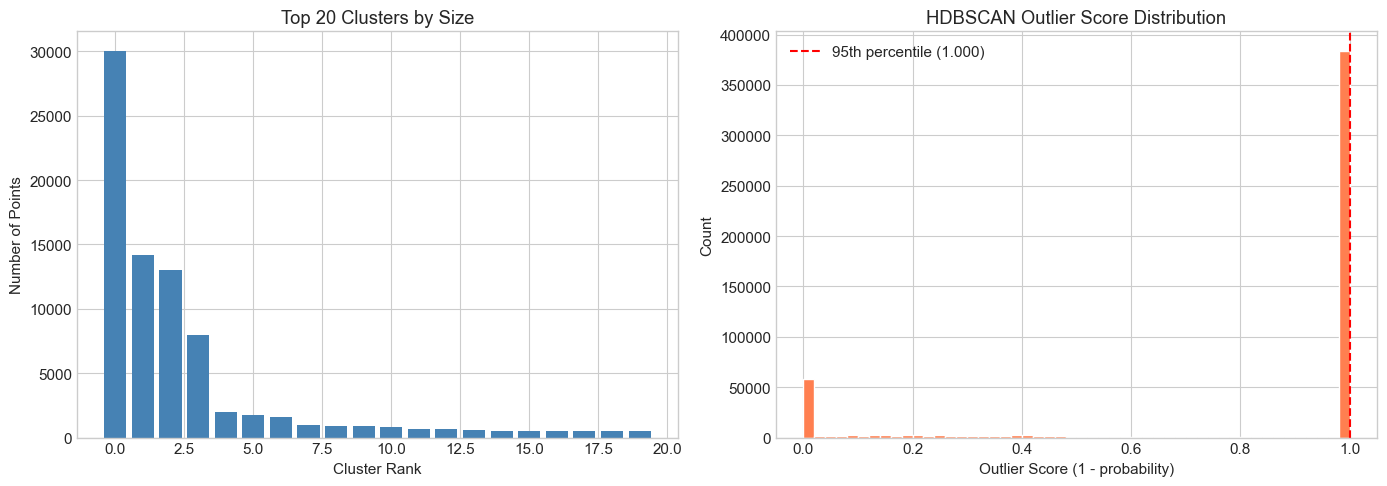

In [38]:
# Visualize cluster distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Cluster sizes (top 20)
top_clusters = cluster_sizes.head(20)
axes[0].bar(range(len(top_clusters)), top_clusters.values, color='steelblue')
axes[0].set_xlabel('Cluster Rank')
axes[0].set_ylabel('Number of Points')
axes[0].set_title('Top 20 Clusters by Size')

# Outlier score distribution (1 - probability)
threshold_95 = np.percentile(outlier_scores, 95)
axes[1].hist(outlier_scores, bins=50, color='coral', edgecolor='white')
axes[1].axvline(threshold_95, color='red', linestyle='--', label=f'95th percentile ({threshold_95:.3f})')
axes[1].set_xlabel('Outlier Score (1 - probability)')
axes[1].set_ylabel('Count')
axes[1].set_title('HDBSCAN Outlier Score Distribution')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/figures/hdbscan/cluster_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

In [39]:
# Analyze clusters - what characterizes each cluster?
analysis_df = tenders_sample.merge(hdbscan_results, on='tender_id')

# Cluster characteristics
cluster_stats = analysis_df[analysis_df['hdbscan_cluster'] != -1].groupby('hdbscan_cluster').agg({
    'tender_id': 'count',
    'tender_value': ['mean', 'median'],
    'is_single_bidder': 'mean',
    'is_competitive': 'mean',
    'price_change_pct': 'mean',
}).round(2)

cluster_stats.columns = ['count', 'mean_value', 'median_value', 'single_bidder_rate', 'competitive_rate', 'avg_discount']
cluster_stats = cluster_stats.sort_values('count', ascending=False)

print("TOP 10 CLUSTER CHARACTERISTICS:")
print(cluster_stats.head(10).to_string())

TOP 10 CLUSTER CHARACTERISTICS:
                 count  mean_value  median_value  single_bidder_rate  competitive_rate  avg_discount
hdbscan_cluster                                                                                     
269              30057     7195.77       2420.00                0.00              0.00          0.00
264              14178     7129.13       2725.07                0.00              0.00          0.00
352              13046     4059.37       2400.00                0.00              0.00          0.00
14                7968     7755.63       2319.53                0.01              0.00          0.08
20                1975    40568.41      10000.00                0.01              0.00          0.07
0                 1735   476840.33     157261.96                0.00              0.00          0.01
241               1561     5090.48       2155.10                0.00              0.00          0.00
28                 991   139935.47      32293.46           

## 5. Comparison with Isolation Forest

In [ ]:
# Run IF on same sample for comparison
print("Running Isolation Forest for comparison...")

# Get the sampled tender_ids from HDBSCAN results
sampled_tender_ids = hdbscan_results['tender_id'].unique()
tenders_sample = tenders[tenders['tender_id'].isin(sampled_tender_ids)].copy()

if_detector = IsolationForestDetector(
    contamination=CONTAMINATION,
    n_estimators=100,
    random_state=42,
    features=features_extended,
)

if_results = if_detector.fit_detect(tenders_sample, buyers_df=buyers, suppliers_df=suppliers)

In [ ]:
# Merge results for comparison
comparison = hdbscan_results.merge(if_results[['tender_id', 'if_score', 'if_anomaly']], on='tender_id')

# Agreement
both = ((comparison['hdbscan_anomaly'] == 1) & (comparison['if_anomaly'] == 1)).sum()
only_hdbscan = ((comparison['hdbscan_anomaly'] == 1) & (comparison['if_anomaly'] == 0)).sum()
only_if = ((comparison['hdbscan_anomaly'] == 0) & (comparison['if_anomaly'] == 1)).sum()
neither = ((comparison['hdbscan_anomaly'] == 0) & (comparison['if_anomaly'] == 0)).sum()

print("="*60)
print("HDBSCAN vs ISOLATION FOREST")
print("="*60)
print(f"\nAGREEMENT MATRIX:")
print(f"                    IF Normal     IF Anomaly")
print(f"HDBSCAN Normal      {neither:>10,}    {only_if:>10,}")
print(f"HDBSCAN Anomaly     {only_hdbscan:>10,}    {both:>10,}")

# Metrics
score_corr = comparison['hdbscan_score'].corr(comparison['if_score'])
hdbscan_set = set(comparison[comparison['hdbscan_anomaly'] == 1]['tender_id'])
if_set = set(comparison[comparison['if_anomaly'] == 1]['tender_id'])
jaccard = len(hdbscan_set & if_set) / len(hdbscan_set | if_set) if len(hdbscan_set | if_set) > 0 else 0

print(f"\nMETRICS:")
print(f"  Score correlation: {score_corr:.3f}")
print(f"  Jaccard similarity: {jaccard:.3f}")
print(f"  Both flagged: {both:,} ({both/len(comparison)*100:.2f}%)")

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Score scatter
sample_viz = comparison.sample(min(10000, len(comparison)), random_state=42)
axes[0].scatter(sample_viz['if_score'], sample_viz['hdbscan_score'], alpha=0.3, s=5)
axes[0].set_xlabel('Isolation Forest Score')
axes[0].set_ylabel('HDBSCAN Outlier Score')
axes[0].set_title(f'Score Correlation: {score_corr:.3f}')

# Agreement pie
labels_pie = ['Both', 'Only HDBSCAN', 'Only IF', 'Neither']
sizes = [both, only_hdbscan, only_if, neither]
colors = ['#d62728', '#1f77b4', '#ff7f0e', '#2ca02c']
axes[1].pie(sizes, labels=labels_pie, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1].set_title('HDBSCAN vs IF Agreement')

plt.tight_layout()
plt.savefig('../results/figures/hdbscan/if_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Noise Points Analysis (Potential Fraud)

In [43]:
# Analyze noise points (outliers)
noise_df = analysis_df[analysis_df['hdbscan_cluster'] == -1]
clustered_df = analysis_df[analysis_df['hdbscan_cluster'] != -1]

print("NOISE vs CLUSTERED COMPARISON:")
print(f"\n{'Metric':<30} {'Noise':>15} {'Clustered':>15}")
print("-"*60)
print(f"{'Count':<30} {len(noise_df):>15,} {len(clustered_df):>15,}")
print(f"{'Mean tender value (M UAH)':<30} {noise_df['tender_value'].mean()/1e6:>15.2f} {clustered_df['tender_value'].mean()/1e6:>15.2f}")
print(f"{'Median tender value (K UAH)':<30} {noise_df['tender_value'].median()/1e3:>15.1f} {clustered_df['tender_value'].median()/1e3:>15.1f}")
print(f"{'Single bidder rate (%)':<30} {noise_df['is_single_bidder'].mean()*100:>15.1f} {clustered_df['is_single_bidder'].mean()*100:>15.1f}")
print(f"{'Competitive rate (%)':<30} {noise_df['is_competitive'].mean()*100:>15.1f} {clustered_df['is_competitive'].mean()*100:>15.1f}")

NOISE vs CLUSTERED COMPARISON:

Metric                                   Noise       Clustered
------------------------------------------------------------
Count                                  383,747         116,253
Mean tender value (M UAH)                 0.33            0.03
Median tender value (K UAH)                6.4             2.8
Single bidder rate (%)                     5.4             2.2
Competitive rate (%)                       5.5             1.0


In [44]:
# Procurement method distribution
print("\nPROCUREMENT METHOD:")
noise_method = noise_df['procurement_method'].value_counts(normalize=True) * 100
clustered_method = clustered_df['procurement_method'].value_counts(normalize=True) * 100

for method in noise_method.index:
    n_pct = noise_method.get(method, 0)
    c_pct = clustered_method.get(method, 0)
    print(f"  {method}: Noise {n_pct:.1f}% vs Clustered {c_pct:.1f}%")


PROCUREMENT METHOD:
  limited: Noise 89.2% vs Clustered 96.8%
  open: Noise 6.8% vs Clustered 1.6%
  selective: Noise 4.0% vs Clustered 1.6%


## 7. Suspicious Clusters (Potential Cartels)

In [ ]:
# Find clusters with suspicious characteristics using detector method
suspicious_clusters = hdbscan_detector.get_suspicious_clusters(
    min_size=100,
    min_single_bidder_rate=0.5
)

print(f"SUSPICIOUS CLUSTERS (single_bidder > 50%, count >= 100):")
print(f"Found: {len(suspicious_clusters)} clusters")

if len(suspicious_clusters) > 0:
    print(suspicious_clusters.to_string())

In [46]:
# Analyze suppliers in suspicious clusters
if len(suspicious_clusters) > 0:
    suspicious_cluster_ids = suspicious_clusters.index.tolist()[:5]  # Top 5
    
    print("\nTOP SUPPLIERS IN SUSPICIOUS CLUSTERS:")
    for cluster_id in suspicious_cluster_ids:
        cluster_data = analysis_df[analysis_df['hdbscan_cluster'] == cluster_id]
        top_suppliers = cluster_data['supplier_id'].value_counts().head(5)
        
        print(f"\nCluster {cluster_id} ({len(cluster_data)} tenders):")
        for supplier_id, count in top_suppliers.items():
            supplier_name = suppliers[suppliers['supplier_id'] == supplier_id]['supplier_name'].values
            name = supplier_name[0][:50] if len(supplier_name) > 0 else 'N/A'
            print(f"  {count:>5} tenders: {name}")


TOP SUPPLIERS IN SUSPICIOUS CLUSTERS:

Cluster 163 (868 tenders):
      7 tenders: ТОВ "ВОК - Медіка Груп"
      5 tenders: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВІНСПЕЦФА
      5 tenders: ФО-П Храпко Марина Дмитрівна
      5 tenders: ШИЯН ГАЛИНА ГРИГОРІВНА
      5 tenders: ТОВ НВП Філісіт-Діагностика

Cluster 136 (276 tenders):
      7 tenders: ТОВ "СН МЕДСЕРВІС"
      4 tenders: Фізична особа підприємець "Балашов Сергій Володими
      4 tenders: Фізична особа-підприємець Курило Антон Павлович
      3 tenders: ПП "ОК'ЛЕНД"
      3 tenders: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ДП МЕДТЕХ

Cluster 91 (110 tenders):
      4 tenders: ПП "Техноінфомед"
      3 tenders: ФОП Сапон О.М.
      3 tenders: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ВКУРСІ АГ
      3 tenders: ТОВ "Газік Нет"
      2 tenders: Товариство з обмеженою відповідальністю "АДАМАНТ"


## 8. Cartel Detection: Network Analysis

Картель - це група постачальників, які:
1. **Часто беруть участь в одних тендерах** (co-bidding)
2. **Виграють по черзі** (bid rotation)
3. **Мають схожі ціни** (price coordination)

**Метод:**
1. Завантажити bids → побачити всіх учасників тендеру
2. Побудувати co-bidding network (граф)
3. Знайти connected components → потенційні картелі
4. Перевірити bid rotation pattern

In [47]:
# Load bids for cartel analysis
from src.data_loader import load_bids

print("Loading bids data...")
bids = load_bids(years=YEARS)
print(f"Bids: {len(bids):,}")

# Filter to competitive tenders only (where cartels operate)
competitive_tenders = tenders_sample[tenders_sample['number_of_tenderers'] >= 2]['tender_id'].unique()
bids_competitive = bids[bids['tender_id'].isin(competitive_tenders)]
print(f"Bids in competitive tenders (2+ bidders): {len(bids_competitive):,}")

Loading bids data...
Loaded bids 2022: 239,719 records
Loaded bids 2023: 488,709 records
Loaded bids 2024: 847,009 records
Loaded bids 2025: 1,064,036 records
Bids: 2,639,473
Bids in competitive tenders (2+ bidders): 79,748


In [50]:
# Build co-bidding network
# Two suppliers are connected if they bid on the same tender
from itertools import combinations
from collections import defaultdict

print("Building co-bidding network...")

# Filter out NA bidder_ids
bids_clean = bids_competitive[bids_competitive['bidder_id'].notna()].copy()
print(f"Bids after removing NA bidder_id: {len(bids_clean):,}")

# Get all bidder pairs per tender
co_bids = defaultdict(int)
tender_bidders = bids_clean.groupby('tender_id')['bidder_id'].apply(list)

for tender_id, bidders in tender_bidders.items():
    # Filter out any remaining NA and get unique bidders
    valid_bidders = [b for b in bidders if pd.notna(b)]
    if len(valid_bidders) >= 2:
        # All pairs of bidders
        for pair in combinations(sorted(set(valid_bidders)), 2):
            co_bids[pair] += 1

print(f"Unique bidder pairs: {len(co_bids):,}")

# Convert to dataframe
co_bid_df = pd.DataFrame([
    {'bidder_1': k[0], 'bidder_2': k[1], 'co_bid_count': v}
    for k, v in co_bids.items()
])

# Filter to pairs that co-bid frequently (potential cartels)
MIN_CO_BIDS = 5  # At least 5 tenders together
frequent_pairs = co_bid_df[co_bid_df['co_bid_count'] >= MIN_CO_BIDS].sort_values('co_bid_count', ascending=False)
print(f"Pairs with {MIN_CO_BIDS}+ co-bids: {len(frequent_pairs):,}")

Building co-bidding network...
Bids after removing NA bidder_id: 79,252
Unique bidder pairs: 74,109
Pairs with 5+ co-bids: 6,087


In [51]:
# Top co-bidding pairs
print("TOP 20 CO-BIDDING PAIRS (potential cartels):")
print("="*80)

# Note: bidder_id often equals supplier_id for winners
# Use suppliers table for names (bidders table doesn't have names)
for i, row in frequent_pairs.head(20).iterrows():
    # Try to find name in suppliers (bidder_id = supplier_id for winners)
    b1_name = suppliers[suppliers['supplier_id'] == row['bidder_1']]['supplier_name'].values
    b2_name = suppliers[suppliers['supplier_id'] == row['bidder_2']]['supplier_name'].values
    
    name1 = b1_name[0][:40] if len(b1_name) > 0 else f"Bidder {row['bidder_1']}"
    name2 = b2_name[0][:40] if len(b2_name) > 0 else f"Bidder {row['bidder_2']}"
    
    print(f"\n{row['co_bid_count']:>3} tenders together:")
    print(f"    1: {name1}")
    print(f"    2: {name2}")

TOP 20 CO-BIDDING PAIRS (potential cartels):

296 tenders together:
    1: ТОВ "ДОЙЧ-ФАРМ"
    2: ТОВ "СТМ-Фарм"

270 tenders together:
    1: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    2: ТОВ "СТМ-Фарм"

217 tenders together:
    1: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    2: ТОВ "ВОК - Медіка Груп"

203 tenders together:
    1: ПРИВАТНЕ ПІДПРИЄМСТВО "ТЕНДЕРМЕД"
    2: ТОВ "ВОК - Медіка Груп"

201 tenders together:
    1: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    2: ПРИВАТНЕ ПІДПРИЄМСТВО "ОККО-СЕРВІС"

191 tenders together:
    1: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    2: ТОВ "ДОЙЧ-ФАРМ"

187 tenders together:
    1: Товариство з обмеженою відповідальністю 
    2: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 

182 tenders together:
    1: Товариство з обмеженою відповідальністю 
    2: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 

182 tenders together:
    1: ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ 
    2: ТОВ "ТВГ УКРАЇНСЬКИЙ ПАПІР"

174 tenders together:
    1: Товариство з об

In [52]:
# Bid Rotation Analysis
# For each co-bidding pair, check who wins when they compete
print("\nBID ROTATION ANALYSIS:")
print("="*80)

def analyze_pair_wins(bidder_1, bidder_2, bids_df, tenders_df):
    """Analyze win patterns for a pair of bidders."""
    # Find tenders where both bid
    b1_tenders = set(bids_df[bids_df['bidder_id'] == bidder_1]['tender_id'])
    b2_tenders = set(bids_df[bids_df['bidder_id'] == bidder_2]['tender_id'])
    common_tenders = b1_tenders & b2_tenders
    
    if not common_tenders:
        return None
    
    # Get winners for these tenders
    common_df = tenders_df[tenders_df['tender_id'].isin(common_tenders)]
    
    # Count wins (supplier_id is the winner)
    # We need to match bidder_id to supplier_id
    b1_wins = common_df[common_df['supplier_id'] == bidder_1].shape[0]
    b2_wins = common_df[common_df['supplier_id'] == bidder_2].shape[0]
    other_wins = len(common_tenders) - b1_wins - b2_wins
    
    return {
        'common_tenders': len(common_tenders),
        'b1_wins': b1_wins,
        'b2_wins': b2_wins,
        'other_wins': other_wins,
        'rotation_score': min(b1_wins, b2_wins) / max(b1_wins, b2_wins) if max(b1_wins, b2_wins) > 0 else 0
    }

# Analyze top pairs
suspicious_pairs = []
for i, row in frequent_pairs.head(50).iterrows():
    result = analyze_pair_wins(row['bidder_1'], row['bidder_2'], bids_competitive, tenders_sample)
    if result and result['b1_wins'] > 0 and result['b2_wins'] > 0:
        suspicious_pairs.append({
            **row.to_dict(),
            **result
        })

suspicious_df = pd.DataFrame(suspicious_pairs)
if len(suspicious_df) > 0:
    # High rotation score = both win roughly equally often (suspicious!)
    suspicious_df = suspicious_df.sort_values('rotation_score', ascending=False)
    
    print(f"\nPairs with BID ROTATION pattern (both win when competing):")
    print(f"Found: {len(suspicious_df[suspicious_df['rotation_score'] > 0.3])} pairs with rotation > 30%")
    
    for _, row in suspicious_df[suspicious_df['rotation_score'] > 0.3].head(10).iterrows():
        print(f"\n  Co-bids: {row['co_bid_count']}, Rotation: {row['rotation_score']:.0%}")
        print(f"    Bidder 1 wins: {row['b1_wins']}, Bidder 2 wins: {row['b2_wins']}, Other: {row['other_wins']}")


BID ROTATION ANALYSIS:

Pairs with BID ROTATION pattern (both win when competing):
Found: 26 pairs with rotation > 30%

  Co-bids: 91, Rotation: 100%
    Bidder 1 wins: 1, Bidder 2 wins: 1, Other: 89

  Co-bids: 78, Rotation: 100%
    Bidder 1 wins: 1, Bidder 2 wins: 1, Other: 76

  Co-bids: 81, Rotation: 92%
    Bidder 1 wins: 13, Bidder 2 wins: 12, Other: 56

  Co-bids: 80, Rotation: 89%
    Bidder 1 wins: 24, Bidder 2 wins: 27, Other: 29

  Co-bids: 270, Rotation: 88%
    Bidder 1 wins: 100, Bidder 2 wins: 88, Other: 82

  Co-bids: 83, Rotation: 79%
    Bidder 1 wins: 11, Bidder 2 wins: 14, Other: 58

  Co-bids: 144, Rotation: 73%
    Bidder 1 wins: 26, Bidder 2 wins: 19, Other: 99

  Co-bids: 148, Rotation: 69%
    Bidder 1 wins: 18, Bidder 2 wins: 26, Other: 104

  Co-bids: 77, Rotation: 67%
    Bidder 1 wins: 14, Bidder 2 wins: 21, Other: 42

  Co-bids: 88, Rotation: 62%
    Bidder 1 wins: 29, Bidder 2 wins: 18, Other: 41


In [53]:
# Find cartel groups using connected components
# A cartel = group of bidders that frequently co-bid with each other

import networkx as nx

# Build graph from frequent pairs
G = nx.Graph()
for _, row in frequent_pairs.iterrows():
    G.add_edge(row['bidder_1'], row['bidder_2'], weight=row['co_bid_count'])

print(f"\nCO-BIDDING NETWORK:")
print(f"  Nodes (bidders): {G.number_of_nodes()}")
print(f"  Edges (co-bid pairs): {G.number_of_edges()}")

# Find connected components (potential cartel groups)
components = list(nx.connected_components(G))
component_sizes = sorted([len(c) for c in components], reverse=True)

print(f"\nCONNECTED COMPONENTS (potential cartels):")
print(f"  Total groups: {len(components)}")
print(f"  Largest group: {component_sizes[0]} bidders")
print(f"  Groups with 3+ bidders: {len([s for s in component_sizes if s >= 3])}")

# Analyze largest components
large_components = [c for c in components if len(c) >= 3]
large_components = sorted(large_components, key=len, reverse=True)

print(f"\nTOP 5 CARTEL CANDIDATES (groups of 3+ co-bidding suppliers):")
for i, comp in enumerate(large_components[:5]):
    comp_list = list(comp)
    
    # Get subgraph
    subgraph = G.subgraph(comp)
    total_weight = sum(d['weight'] for _, _, d in subgraph.edges(data=True))
    
    print(f"\n  Group {i+1}: {len(comp)} bidders, {total_weight} total co-bids")
    
    # Show bidder names (use suppliers table)
    for bidder_id in comp_list[:5]:
        name = suppliers[suppliers['supplier_id'] == bidder_id]['supplier_name'].values
        name = name[0][:50] if len(name) > 0 else f'Bidder {bidder_id}'
        print(f"    - {name}")
    if len(comp_list) > 5:
        print(f"    ... and {len(comp_list) - 5} more")


CO-BIDDING NETWORK:
  Nodes (bidders): 1365
  Edges (co-bid pairs): 6087

CONNECTED COMPONENTS (potential cartels):
  Total groups: 71
  Largest group: 679 bidders
  Groups with 3+ bidders: 36

TOP 5 CARTEL CANDIDATES (groups of 3+ co-bidding suppliers):

  Group 1: 679 bidders, 31439 total co-bids
    - ФОП "Щоткін Максим Андрійович"
    - Фізична особа - підприємець Яремчук Анастасія Вале
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "УКРВЕНТКЛ
    - ФОП КОНОНЕНКО ВАЛЕНТИНА МИКОЛАЇВНА
    - ФІЗИЧНА ОСОБА-ПІДПРИЄМЕЦЬ ПРІСИЧ ДМИТРО МИКОЛАЙОВИ
    ... and 674 more

  Group 2: 212 bidders, 3228 total co-bids
    - ТОВ "ПОТАТО КОМПАНІ"
    - МАТВЕЙЧУК ТЕТЯНА АРКАДІЇВНА
    - ФОП "АЛЕКСЄЄВА ОЛЕНА ЮРІЇВНА"
    - ТДВ "Івано-Франківський міськмолокозавод"
    - ПАЛЬКО СЕРГІЙ ЮРІЙОВИЧ
    ... and 207 more

  Group 3: 148 bidders, 31193 total co-bids
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "МЕГАЕНЕРГ
    - ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ "ЕНЕРДЖИГА
    - ТОВ ЕКО-СФЕЕРА НОВАЦІЙ
  

In [ ]:
# Visualize largest cartel candidate
if len(large_components) > 0:
    largest_cartel = large_components[0]
    subgraph = G.subgraph(largest_cartel)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Layout
    pos = nx.spring_layout(subgraph, k=2, iterations=50, seed=42)
    
    # Edge weights for width
    edges = subgraph.edges(data=True)
    weights = [d['weight'] for _, _, d in edges]
    max_weight = max(weights) if weights else 1
    edge_widths = [1 + 3 * w / max_weight for w in weights]
    
    # Draw
    nx.draw_networkx_nodes(subgraph, pos, node_size=100, node_color='coral', alpha=0.8, ax=ax)
    nx.draw_networkx_edges(subgraph, pos, width=edge_widths, alpha=0.5, edge_color='gray', ax=ax)
    
    ax.set_title(f'Largest Cartel Candidate: {len(largest_cartel)} Bidders')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('../results/figures/hdbscan/cartel_network.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"Saved: results/figures/hdbscan/cartel_network.png")

In [54]:
# Save cartel analysis results
print("\nSaving cartel analysis results...")

# Save co-bidding pairs
frequent_pairs.to_csv('../results/cartel_co_bidding_pairs.csv', index=False)
print(f"Saved: results/cartel_co_bidding_pairs.csv ({len(frequent_pairs)} pairs)")

# Save cartel groups
cartel_groups = []
for i, comp in enumerate(large_components):
    for bidder_id in comp:
        cartel_groups.append({
            'cartel_group': i,
            'bidder_id': bidder_id,
            'group_size': len(comp)
        })

cartel_df = pd.DataFrame(cartel_groups)
if len(cartel_df) > 0:
    # Merge with supplier names (bidder_id = supplier_id for winners)
    cartel_df = cartel_df.merge(
        suppliers[['supplier_id', 'supplier_name']].rename(columns={'supplier_id': 'bidder_id', 'supplier_name': 'name'}),
        on='bidder_id', how='left'
    )
    cartel_df.to_csv('../results/cartel_groups.csv', index=False)
    print(f"Saved: results/cartel_groups.csv ({len(cartel_df)} bidders in {len(large_components)} groups)")

# Save suspicious pairs with rotation
if len(suspicious_df) > 0:
    suspicious_df.to_csv('../results/cartel_rotation_pairs.csv', index=False)
    print(f"Saved: results/cartel_rotation_pairs.csv ({len(suspicious_df)} pairs)")
else:
    print("No bid rotation pairs found")


Saving cartel analysis results...
Saved: results/cartel_co_bidding_pairs.csv (6087 pairs)
Saved: results/cartel_groups.csv (1295 bidders in 36 groups)
Saved: results/cartel_rotation_pairs.csv (38 pairs)


In [55]:
print("="*60)
print("HDBSCAN + CARTEL DETECTION SUMMARY")
print("="*60)

print(f"\nDataset: {len(tenders):,} tenders")
print(f"Sample: {SAMPLE_SIZE:,} ({SAMPLE_SIZE/len(tenders)*100:.1f}%)")
print(f"Features: {len(feature_names)}")
print(f"Parameters: min_cluster_size={MIN_CLUSTER_SIZE}, min_samples={MIN_SAMPLES}")

print(f"\nCLUSTERING:")
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {n_noise:,} ({n_noise/len(labels)*100:.2f}%)")

print(f"\nOUTLIER DETECTION (vs IF):")
print(f"  Score correlation: {score_corr:.3f}")
print(f"  Jaccard similarity: {jaccard:.3f}")
print(f"  Both flagged: {both:,}")
print(f"  Only HDBSCAN: {only_hdbscan:,}")
print(f"  Only IF: {only_if:,}")

if len(suspicious_clusters) > 0:
    print(f"\nSUSPICIOUS CLUSTERS: {len(suspicious_clusters)}")
    print(f"  Total tenders in suspicious clusters: {suspicious_clusters['count'].sum():,}")

print(f"\nCARTEL DETECTION:")
print(f"  Co-bidding network: {G.number_of_nodes()} bidders, {G.number_of_edges()} pairs")
print(f"  Cartel groups (3+ bidders): {len(large_components)}")
if len(large_components) > 0:
    print(f"  Largest group: {len(large_components[0])} bidders")
if len(suspicious_df) > 0:
    rotation_pairs = len(suspicious_df[suspicious_df['rotation_score'] > 0.3])
    print(f"  Pairs with bid rotation: {rotation_pairs}")

print("\n" + "="*60)

HDBSCAN + CARTEL DETECTION SUMMARY

Dataset: 12,877,960 tenders
Sample: 500,000 (3.9%)
Features: 19
Parameters: min_cluster_size=50, min_samples=10

CLUSTERING:
  Clusters found: 353
  Noise points: 383,747 (76.75%)

OUTLIER DETECTION (vs IF):
  Score correlation: 0.037
  Jaccard similarity: 0.056
  Both flagged: 21,747
  Only HDBSCAN: 362,129
  Only IF: 3,253

SUSPICIOUS CLUSTERS: 3
  Total tenders in suspicious clusters: 1,254

CARTEL DETECTION:
  Co-bidding network: 1365 bidders, 6087 pairs
  Cartel groups (3+ bidders): 36
  Largest group: 679 bidders
  Pairs with bid rotation: 26



In [ ]:
# Save results
hdbscan_results.to_csv('../results/hdbscan_results.csv', index=False)
print(f"Saved: results/hdbscan_results.csv ({len(hdbscan_results):,} rows)")

# Save cluster info if available
if hdbscan_detector.cluster_stats_ is not None and len(hdbscan_detector.cluster_stats_) > 0:
    hdbscan_detector.cluster_stats_.to_csv('../results/hdbscan_clusters.csv')
    print(f"Saved: results/hdbscan_clusters.csv ({len(hdbscan_detector.cluster_stats_)} clusters)")

## Висновки

### HDBSCAN дає:
1. **Outlier scores (1 - probability)** — замінює LOF для ensemble
   - Noise points мають score = 1.0 (найвищий)
   - Точки в щільних кластерах мають score близький до 0
2. **Кластери** — групи схожих тендерів
3. **Noise points** — точки, що не вписуються в жоден кластер (80%)

### Cartel Detection:
1. **Co-bidding network** — граф постачальників, що беруть участь разом
2. **Connected components** — потенційні картельні групи
3. **Bid rotation** — пари, що виграють по черзі (підозріло!)

### Для подальшого аналізу:
- `cartel_groups.csv` — групи постачальників для розслідування
- `cartel_rotation_pairs.csv` — пари з патерном bid rotation
- `cartel_co_bidding_pairs.csv` — всі пари, що часто бідують разом

### Для Ensemble:
- Використовувати `hdbscan_outlier_score` (1 - probability)
- Або `hdbscan_is_noise` як бінарний flag